In [6]:
!pip install opencv-python -q
!pip install dictances -q
!pip install scikit-learn -q
import random
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from dictances import bhattacharyya


[notice] A new release of pip is available: 23.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
def get_bounding_boxes(annot):
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin,ymin,xmax,ymax))
    return bbox

In [ ]:
def image_resizing(dog_images):
    for i in range(len(dog_images)):
        bbox = get_bounding_boxes(annotations[i])
        dog = get_image(annotations[i])
        image = Image.open(dog)
        for j in range(len(bbox)):
            image_2 = image.crop(bbox[j])
            image_2 = image_2.resize((100,100), Image.ANTIALIAS)
            new_path = dog.replace('../input/stanford-dogs-dataset/images/Images/','./Cropped/')
            new_path = new_path.replace('.jpg','-' + str(j) + '.jpg')
            image_2 = image_2.convert('RGB')
            head, tail = os.path.split(new_path)
            Path(head).mkdir(parents=True, exist_ok=True)
            image_2.save(new_path)


In [ ]:
def image_intensity_normalization():
    #cocker_spaniel = []
    #groenendael = []
    #greater_swiss_mountain_dog = []
    #bouvier_des_flandres = []
    folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
               "n02107574-Greater_Swiss_Mountain_dog"]
    collect = {}
    for folder in folders:
        random_files = random.sample(os.listdir(folder), 2)
        collect[folder] = random_files
    
    #append to their own classes, but for now use this 
    # convert image to grayscale   
    grayscale_images = []    
    for folder, image in collect.items():        
        for img in image:
            path = f"{folder}/{img}"
            loaded_image = cv.imread(path)
            grayscale_images.append(cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY))
 
    # plot 8 grayscale image
    for image in grayscale_images:
        assert image is not None
        plt.hist(image.ravel(), 256, [0, 256])
        plt.show()
        
    # perform and plot histogram equalization
    count = 1
    for image in grayscale_images:
        assert image is not None
        histogram, bins = np.histogram(image.flatten(), 256, [0,256])
        cdf = histogram.cumsum()
        cdf_normalized = cdf * float(histogram.max()) / cdf.max()
        equ = cv.equalizeHist(image)
        res = np.hstack((image, equ))
        cv.imwrite(f"temp_{count}.png", res)
        count += 1
                
        plt.plot(cdf_normalized, color = 'k')
        plt.hist(image.flatten(), 256, [0, 256], color = 'y')
        plt.xlim([0, 256])
        plt.legend(('cdf', 'histogram'), loc = 'upper left')
        plt.show()
        
    # What I observed when I plotted the images side by side is the equalized image 
    # is a bit brighter than the grayscaled one.

In [ ]:
def rgb_histogram():
    folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
               "n02107574-Greater_Swiss_Mountain_dog"]
    collect = {}
    for folder in folders:
        random_files = random.sample(os.listdir(folder), 1)
        collect[folder] = random_files
        
    # plot images with RGB histogram
    loaded_images = []
    for folder, image in collect.items():        
        for img in image:
            path = f"{folder}/{img}"
            loaded_images.append(cv.imread(path))
    
    for image in loaded_images:
        assert image is not None
        colors = ('r', 'g', 'b')
        
        for i, color in enumerate(colors):
            hist = cv.calcHist([image], [i], None, [256], [0,256])
            plt.plot(hist, color = color)
            plt.xlim([0, 256])
            plt.xlabel("Intensity")
            plt.ylabel("Pixel Count")
        plt.show()

In [ ]:
def histogram_comparison():
    folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
               "n02107574-Greater_Swiss_Mountain_dog"]
    
    count = 2
    folders = random.sample(folders, count)
    collect = {}
    for folder in folders:
        random_files = random.sample(os.listdir(folder), count)
        collect[folder] = random_files
        count -= 1
    
    # convert image to grayscale   
    same_class_grayscale_images = []   
    diff_class_grayscale_images = []
    for folder, image in collect.items():     
        for img in image:
            path = f"{folder}/{img}"
            loaded_image = cv.imread(path)
            grayscale = cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY)
            if list(collect.keys())[0] == folder:
                same_class_grayscale_images.append(grayscale)
            else:
                diff_class_grayscale_images.append(grayscale)
                diff_class_grayscale_images.append(same_class_grayscale_images[0])
    
    
    # histogram comparison
    
    # same class
    for image in same_class_grayscale_images:
        assert image is not None
        plt.hist(image.ravel(), 256, [0, 256])
        plt.show()
    
    # different class               
    for image in diff_class_grayscale_images:
        assert image is not None
        plt.hist(image.ravel(), 256, [0, 256])
        plt.show()
    
    # histogram comparison using metrics
    
    # same class
    
    # Euclidean distance
    same_ed = np.linalg.norm(same_class_grayscale_images[1] - same_class_grayscale_images[0])
    
    # Manhattan distance
    same_md = np.sum(np.abs(same_class_grayscale_images[1] - same_class_grayscale_images[0]))
    
    # Bhattacharyya distance
    same_bd = bhattacharyya(same_class_grayscale_images[1] - same_class_grayscale_images[0])
    
    # Histogram intersection
    same_hi = np.sum(np.minimum(same_class_grayscale_images[1] - same_class_grayscale_images[0]))
    
    
    # different class
    
    # Euclidean distance
    diff_ed = np.linalg.norm(diff_class_grayscale_images[1] - diff_class_grayscale_images[0])
    
    # Manhattan distance
    diff_md = np.sum(np.abs(diff_class_grayscale_images[1] - diff_class_grayscale_images[0]))
    
    # Bhattacharyya distance
    diff_bd = bhattacharyya(diff_class_grayscale_images[1] - diff_class_grayscale_images[0])
    
    # Histogram intersection
    diff_hi = np.sum(np.minimum(diff_class_grayscale_images[1] - diff_class_grayscale_images[0]))

In [ ]:
def image_feature_descriptor():
    folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
               "n02107574-Greater_Swiss_Mountain_dog"]
    
    collect = {}
    folder = random.sample(folders, 1)[0]
    random_files = random.sample(os.listdir(folder), 1)
    collect[folder] = random_files
    
    img = None
    for folder, images in collect.items():
        for img in images:
            path = f"{folder}/{img}"
            loaded_image = cv.imread(path)
            img = cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY)
    
    orb = cv.ORB_create(edgeThreshold=7, patchSize=30, nlevels=8, fastThreshold=20, scaleFactor=1.2, 
                                WTA_K=2,scoreType=cv.ORB_HARRIS_SCORE, firstLevel=0, nfeatures=30)
    kp = orb.detect(img, None)
    img2 = cv.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
    plt.imshow(img2)
    plt.show()

In [82]:
def dimensionality_reduction():
    folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
               "n02107574-Greater_Swiss_Mountain_dog"]

    folders = random.sample(folders, 2)

    files = [f for f in os.listdir(folders[0]) if os.path.isfile(os.path.join(folders[0], f))]
    no_of_files = [len(files)]
    
    files = [f for f in os.listdir(folders[1]) if os.path.isfile(os.path.join(folders[1], f))]
    no_of_files.append(len(files))

    collect = {}
    for folder, count in zip(folders, no_of_files):
        random_files = random.sample(os.listdir(folder), count)
        collect[folder] = random_files

    # convert image to grayscale   
    grayscale_images = []    
    for folder, image in collect.items():        
        for img in image:
            path = f"{folder}/{img}"
            loaded_image = cv.imread(path)
            grayscale_images.append(cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY))
            
    # normalizing the dataset
    fit_data = []
    for image in grayscale_images:
        assert image is not None
        histogram, bins = np.histogram(image.flatten(), 256, [0,256])
        cdf = histogram.cumsum()
        cdf_normalized = cdf * float(histogram.max()) / cdf.max()
        equ = cv.equalizeHist(image)
        fit_data.append(equ)
    
    # perfrom PCA dimension reduction
    transformed_data = []
    pca = PCA(n_components = 2) 
    for data in fit_data:
        transformed_data.append(pca.fit_transform(data))
    
    # plotting
    colors = ('y', 'k')
    for i, (color, data) in enumerate(zip(colors, transformed_data)):
        plt.scatter(data[:, 0], data[:, 1], color=color)
    plt.show()

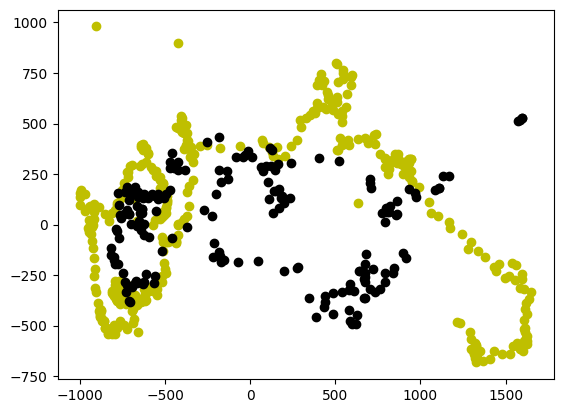

In [83]:
dimensionality_reduction()